# Convolution Neural Network Using TensorFlow

## Processing the data

In [2]:
import gzip as gz
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import random

In [7]:
train_x = gz.open("Data/train-images-idx3-ubyte.gz", "r")
train_y = gz.open("Data/train-labels-idx1-ubyte.gz", "r")

In [8]:
img_size = 28
num_images = 60000

In [9]:
train_x.read(16)
train_x = train_x.read(img_size * img_size * num_images)
train_x = np.frombuffer(train_x, dtype=np.uint8())
train_x = train_x.reshape(num_images, img_size, img_size)

In [10]:
train_y.read(8)
train_y = train_y.read(num_images)
train_y = np.frombuffer(train_y, dtype=np.uint8)
train_y = train_y.tolist()

In [11]:
for i in range(len(train_y)):
    index = train_y[i]
    train_y[i] = np.zeros((1, 10), dtype=np.float32)
    np.put(train_y[i], index, 1)

In [12]:
np.save("Data/train_features.npy", train_x)
np.save("Data/train_labels.npy", train_y)

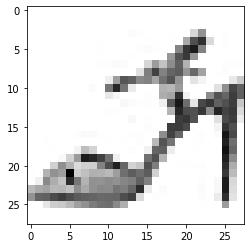

In [6]:
plt.imshow(train_x[np.random.randint(0, len(train_y))], cmap="binary")
plt.show()

## The model

First the data is loaded and converted to tensors.

In [43]:
train_x = np.load("Data/train_features.npy")
train_y = np.load("Data/train_labels.npy")
# c = list(zip(train_x, train_y))
# random.shuffle(c)
# train_x, train_y = zip(*c)
train_x = tf.convert_to_tensor(train_x, dtype=tf.float32)
train_x = train_x / 255.0
train_x = train_x[..., tf.newaxis]
train_y = tf.convert_to_tensor(train_y, dtype=tf.float32)
train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y)).shuffle(1000).batch(32)

In [44]:
class TrainModel(tf.keras.Model):
    def __init__(self):
        super(TrainModel, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(8, 3, activation="relu")
        self.pool1 = tf.keras.layers.MaxPool2D()
        self.flatten = tf.keras.layers.Flatten()
        self.d1 = tf.keras.layers.Dense(128, activation="relu")
        self.d2 = tf.keras.layers.Dense(32, activation="relu")
        self.d3 = tf.keras.layers.Dense(10, activation="softmax")

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.flatten(x)
        x = self.d1(x)
        x = self.d2(x)
        return self.d3(x)

model = TrainModel()

In [45]:
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

In [8]:
model(train_x)

<tf.Tensor: shape=(60000, 10), dtype=float32, numpy=
array([[0.07861502, 0.12405796, 0.10760193, ..., 0.10757466, 0.11715619,
        0.1062955 ],
       [0.0819091 , 0.12799802, 0.09670891, ..., 0.1124753 , 0.11879195,
        0.09931836],
       [0.06471206, 0.12625864, 0.11894716, ..., 0.11428633, 0.1217747 ,
        0.13195713],
       ...,
       [0.06869063, 0.10570644, 0.10647908, ..., 0.12192409, 0.1316709 ,
        0.12835005],
       [0.08184437, 0.12887725, 0.11159392, ..., 0.10678302, 0.11444664,
        0.11068818],
       [0.06699902, 0.12529801, 0.10691882, ..., 0.1037627 , 0.13876262,
        0.11078739]], dtype=float32)>

In [52]:
with tf.GradientTape() as g:
    preds = model(train_x[0:10])
    loss_funct = loss(train_y[0:10], preds)
gradients = g.gradient(loss_funct, model.trainable_variables)
optimizer.apply_gradients(zip(gradients, model.trainable_variables))

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=6>

In [9]:
# Just messing with tensorflows gradient tape
x = tf.constant(5.0)
with tf.GradientTape() as g:
  g.watch(x)
  y = 2*x**2 + 5*x
dy_dx = g.gradient(y, x)

In [10]:
dy_dx

<tf.Tensor: shape=(), dtype=float32, numpy=25.0>

In [9]:
model.trainable_variables

[<tf.Variable 'train_model/conv2d/kernel:0' shape=(3, 3, 1, 8) dtype=float32, numpy=
 array([[[[ 0.21061945,  0.16250265, -0.0401371 ,  0.01714382,
            0.08974344,  0.21098095,  0.16236982,  0.23874414]],
 
         [[ 0.00134268,  0.1618773 , -0.22712009, -0.05956858,
            0.10641602, -0.08540712,  0.06142357, -0.07926685]],
 
         [[-0.12894826, -0.14725788,  0.21853852,  0.20329025,
           -0.13788545,  0.05260271, -0.2622058 , -0.06019445]]],
 
 
        [[[ 0.0401186 ,  0.2100651 , -0.2170614 , -0.22825415,
           -0.21050602,  0.18886036, -0.19400603,  0.2186397 ]],
 
         [[ 0.17825124,  0.00834203,  0.12345842,  0.14784467,
           -0.18948688,  0.09897554, -0.26093903,  0.07837662]],
 
         [[ 0.07234213, -0.0698442 , -0.18174954,  0.17883405,
           -0.13278684,  0.00453991,  0.25082618, -0.03450847]]],
 
 
        [[[-0.05255444, -0.21081223,  0.07778472,  0.18340117,
           -0.18424842, -0.01908797,  0.1714327 ,  0.0242137 ]],
 

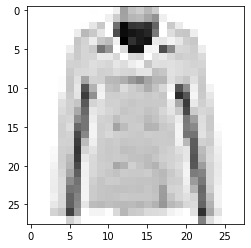

In [56]:
plt.imshow(tf.squeeze(train_x[np.random.randint(0, len(train_y))]), cmap="binary")
plt.show()

In [53]:
loss(train_y[0:10], preds)

<tf.Tensor: shape=(), dtype=float32, numpy=1.9940599>